# SPOTIFY MUSIC RECOMMENDATION SYSTEM USING CLUSTERING 

🔹. Spotify Music Recommendation System
- Goal: Cluster songs based on audio features to recommend similar tracks.
- Algorithms: K-Means, DBSCAN.
- Dataset: Spotify Songs Dataset
- Evaluation: Silhouette Score to tune K, DB Index to compare clustering quality.



In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import joblib 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score


## Step 1: Load Dataset


In [2]:
df = pd.read_csv("SpotifyFeatures.csv") 
print("Dataset Shape:", df.shape)


Dataset Shape: (232725, 18)


## Step 2: Select Important Features


In [3]:
features = ['danceability', 'energy', 'valence', 'tempo', 'loudness', 'acousticness', 'instrumentalness', 'liveness', 'speechiness'] 
cols_to_save=['track_name']+features
data = df[cols_to_save].dropna()


## Step 3: Downsample


In [4]:
# Already sampled
data_sampled = data.sample(n=30000, random_state=42)

# Save sampled data
data_sampled.to_csv("sampled_spotify_data.csv", index=False)

## Step 4: Standardize Features


In [5]:
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(data_sampled[features])


## Step 5: MiniBatch K-Means Clustering


In [6]:
kmeans = MiniBatchKMeans(n_clusters=6, random_state=42, batch_size=1024)
kmeans_labels = kmeans.fit_predict(X_scaled) #train the model and assign cluster labels


C:\Users\naman\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\naman\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\naman\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\naman\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\naman\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

## Step 6: K-Means Evaluation


In [7]:
sil_k = silhouette_score(X_scaled, kmeans_labels) # Higher is better(max=1)
db_k = davies_bouldin_score(X_scaled, kmeans_labels) # Lower is better (min=0)
print(f"K-Means -> Silhouette Score: {sil_k:.4f}, DB Index: {db_k:.4f}")


K-Means -> Silhouette Score: 0.1694, DB Index: 1.6251


## Step 7: DBSCAN Clustering
 

In [8]:
dbscan = DBSCAN(eps=1.6, min_samples=10)
db_labels = dbscan.fit_predict(X_scaled) 
mask = db_labels != -1 
if len(set(db_labels[mask])) > 1:
    sil_db = silhouette_score(X_scaled[mask], db_labels[mask]) 
    db_db = davies_bouldin_score(X_scaled[mask], db_labels[mask])
    print(f"DBSCAN -> Silhouette Score: {sil_db:.4f}, DB Index: {db_db:.4f}")
else: 
    print("DBSCAN: Not enough clusters to evaluate.")


DBSCAN: Not enough clusters to evaluate.


## Step 8: Visualize Clusters (KMeans)


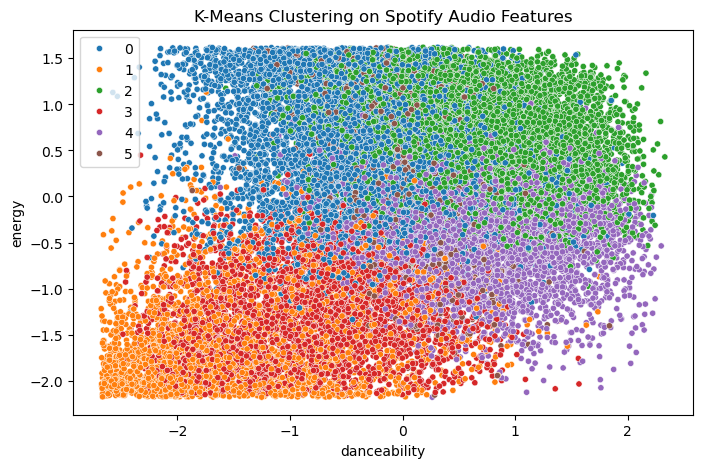

In [9]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=kmeans_labels, palette='tab10', s=20) 
plt.title("K-Means Clustering on Spotify Audio Features") 
plt.xlabel(features[0]) 
plt.ylabel(features[1]) 
plt.show()



## Step 9: Add Cluster Labels


In [10]:
clustered_df = data_sampled.copy() 
clustered_df['Cluster'] = kmeans_labels.astype(str)



## Step 10: Recommend Similar Songs


In [11]:
def recommend_similar_songs(index, n=5):
    target_cluster = kmeans_labels[index] 
    similar_songs = clustered_df[clustered_df['Cluster'] == str(target_cluster)].sample(n=n)
    return similar_songs
print("\nRecommended Songs:")
print(recommend_similar_songs(123))




Recommended Songs:
                     track_name  danceability  energy  valence    tempo  \
232638  Why Can't We Be Friends         0.772   0.740    0.962   92.713   
179553              The Chicken         0.756   0.700    0.703  105.994   
90000                     Fuego         0.820   0.587    0.856  129.244   
188402                Irukandji         0.758   0.461    0.822  150.048   
22482                     Yexit         0.706   0.974    0.902  160.001   

        loudness  acousticness  instrumentalness  liveness  speechiness  \
232638    -7.002       0.24200           0.00000    0.3070       0.0377   
179553    -7.600       0.05260           0.86600    0.2860       0.0384   
90000     -8.681       0.08390           0.00000    0.0492       0.0946   
188402   -14.625       0.00935           0.00512    0.2510       0.0933   
22482     -3.462       0.00655           0.09470    0.1970       0.0685   

       Cluster  
232638       2  
179553       2  
90000        2  
188402    

## Step 11: Get Cluster for Song by Name


In [12]:
def get_cluster_for_song(song_name):
    row = df[df['track_name'] == song_name][features] 
    if row.empty:
        return "Song not found."
        scaled = scaler.transform(row)
        cluster = kmeans.predict(scaled) 
        return cluster[0]

print(get_cluster_for_song("Let It Be"))


None


## Step 12: Cluster Summaries



In [13]:
print("\nAverage Features per Cluster:")
print(clustered_df.groupby('Cluster')[features].mean())




Average Features per Cluster:
         danceability    energy   valence       tempo   loudness  \
Cluster                                                            
0            0.496926  0.725511  0.334966  133.494015  -6.311813   
1            0.295937  0.175644  0.157688  102.942751 -20.515649   
2            0.678218  0.757743  0.707225  120.203946  -6.007656   
3            0.403842  0.241094  0.237133  108.929803 -14.742692   
4            0.685155  0.463029  0.548929  108.384452  -9.895075   
5            0.560341  0.671189  0.409031   97.734445 -11.892151   

         acousticness  instrumentalness  liveness  speechiness  
Cluster                                                         
0            0.111669          0.096338  0.220721     0.087343  
1            0.835859          0.829193  0.140710     0.044915  
2            0.128808          0.040491  0.201836     0.104629  
3            0.819222          0.040744  0.194553     0.054987  
4            0.469884          0.1

## Step 13: Save Models


In [14]:
joblib.dump(kmeans, 'kmeans_spotify.pkl')
joblib.dump(scaler, 'scaler_spotify.pkl') 
print("\nModel and Scaler saved successfully.")



Model and Scaler saved successfully.


## Step 14: Pairplot


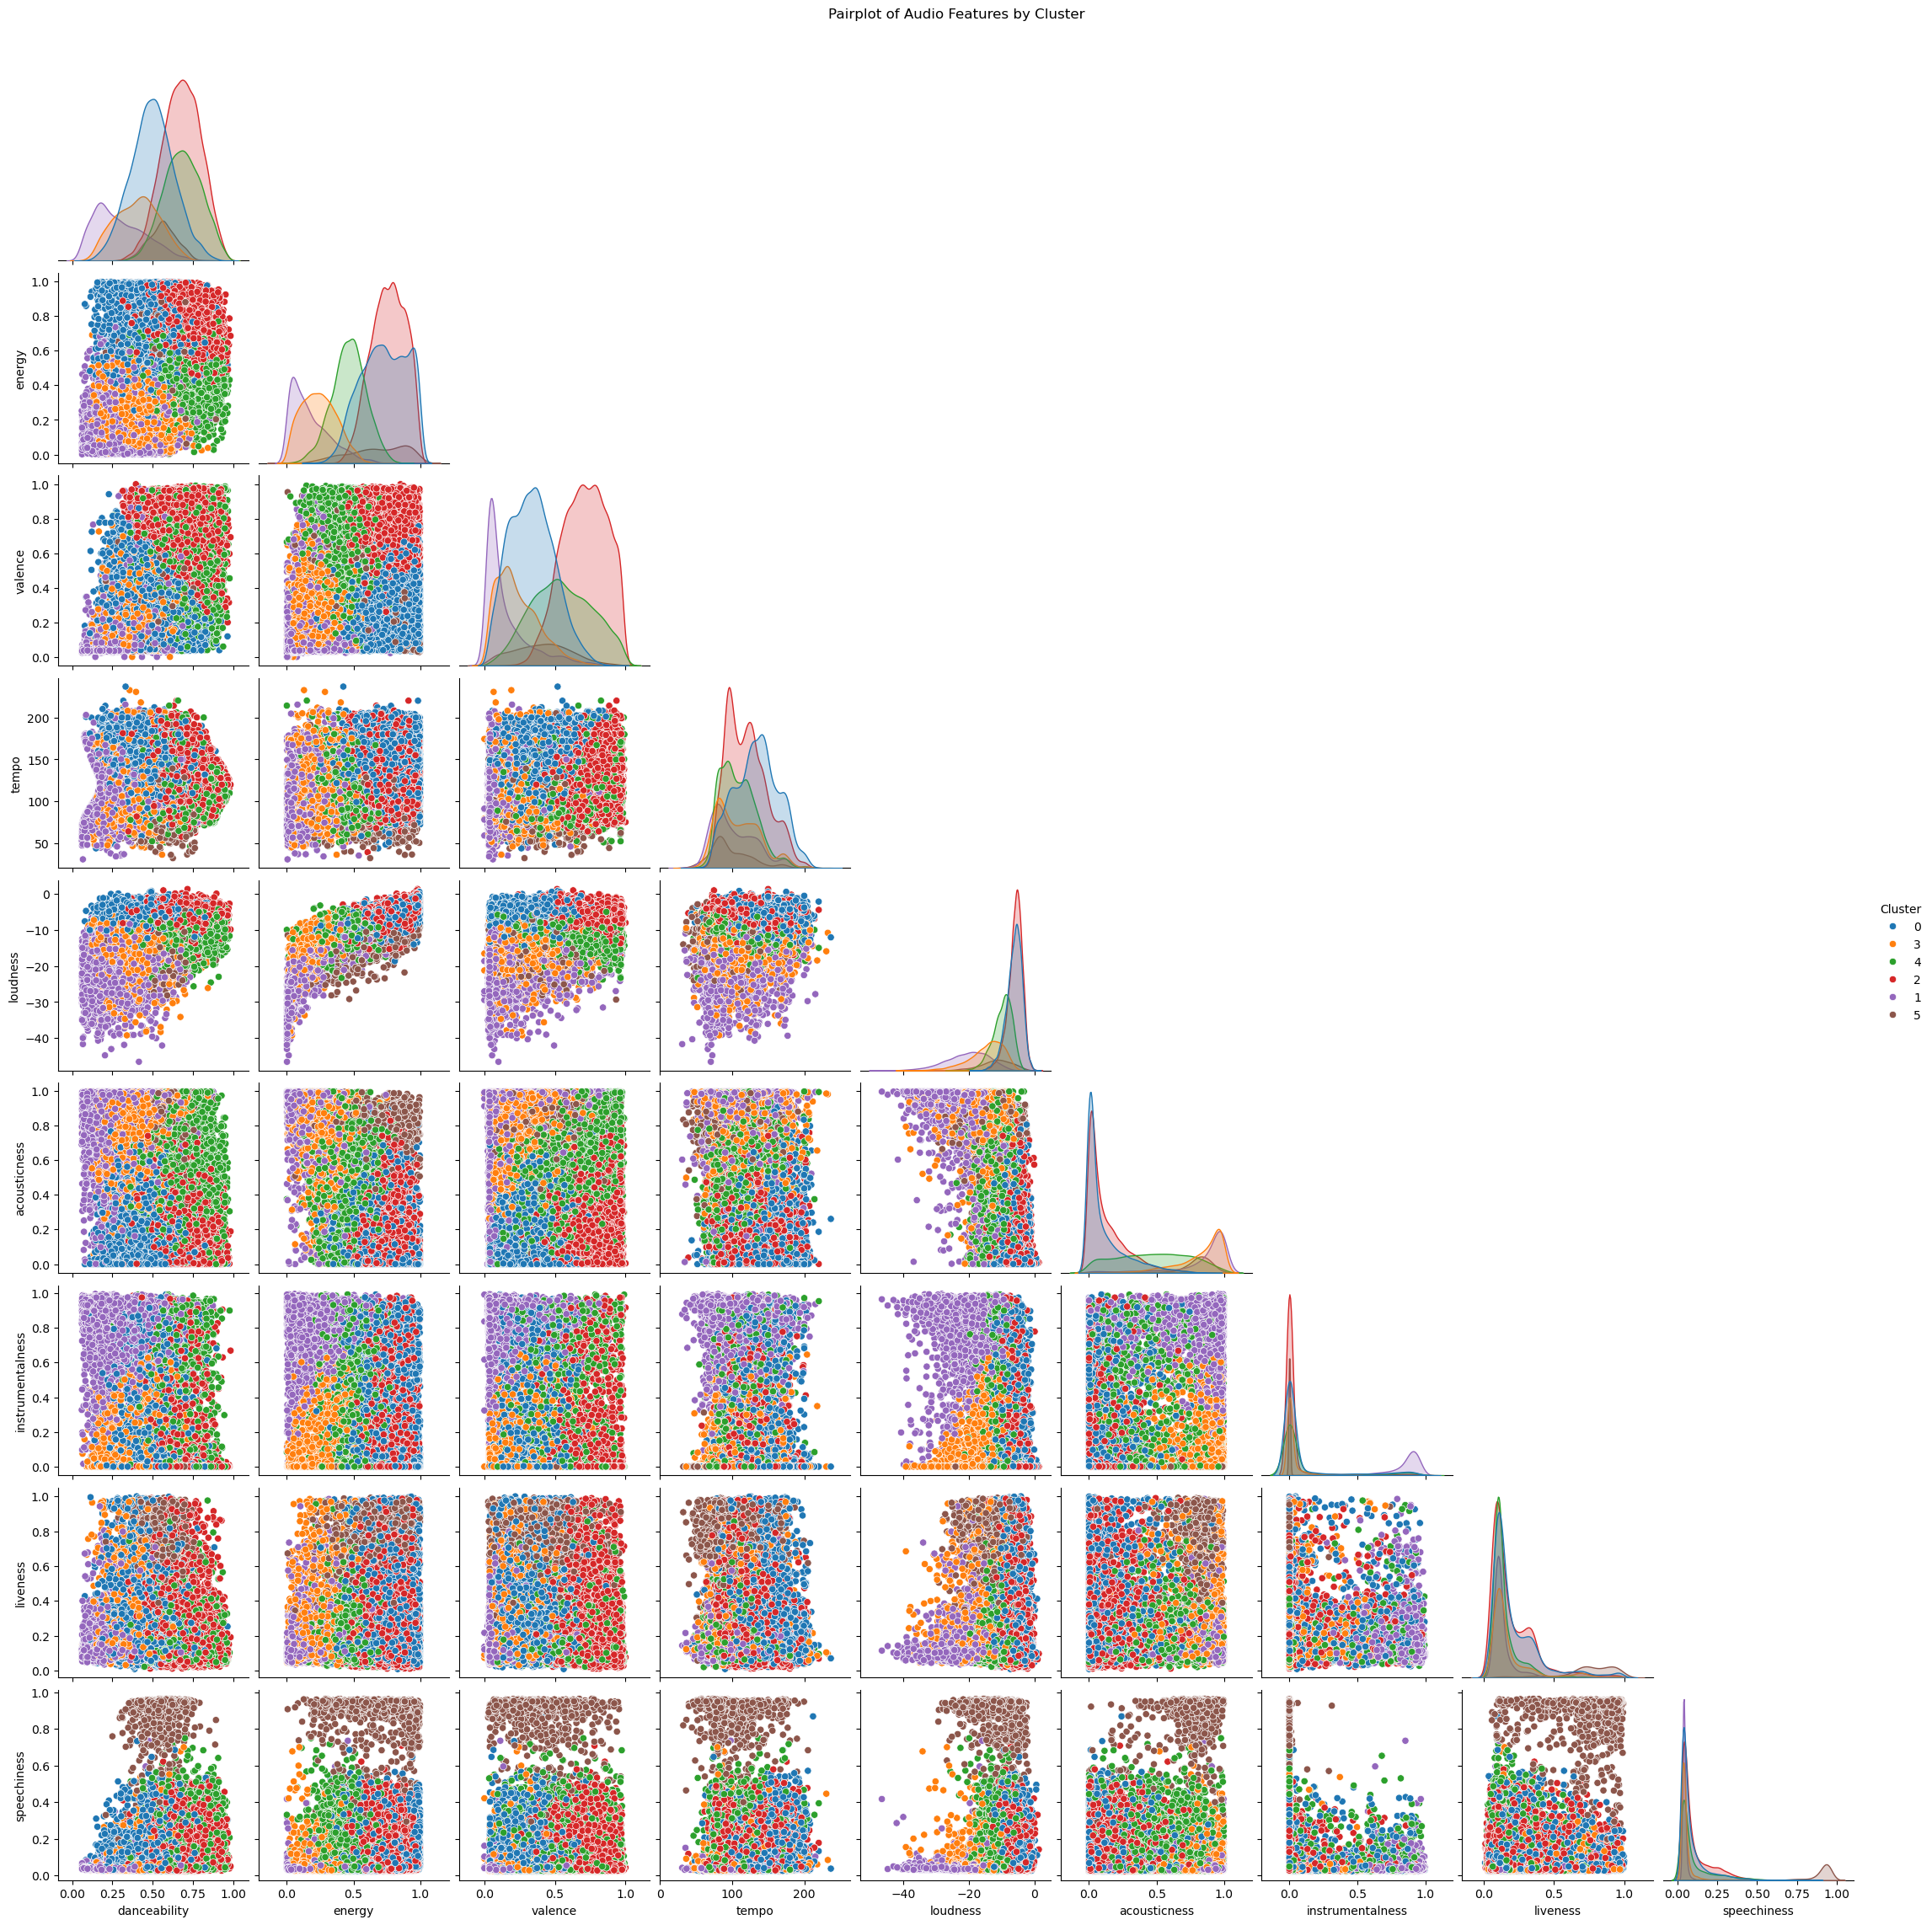

In [15]:
sns.pairplot(clustered_df[features + ['Cluster']], hue='Cluster', palette='tab10', corner=True)
plt.suptitle("Pairplot of Audio Features by Cluster", y=1.02) 
plt.show()


## Step 15: Boxplots for Each Feature


C:\Users\naman\AppData\Local\Temp\ipykernel_12580\553004632.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clustered_df, x='Cluster', y=feature, palette='coolwarm')


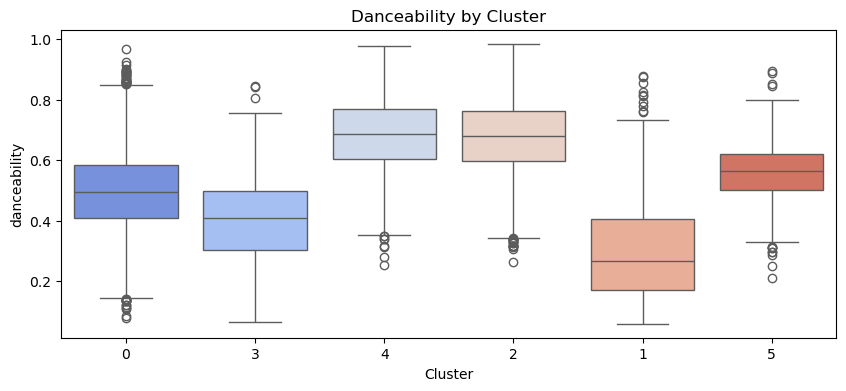

C:\Users\naman\AppData\Local\Temp\ipykernel_12580\553004632.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clustered_df, x='Cluster', y=feature, palette='coolwarm')


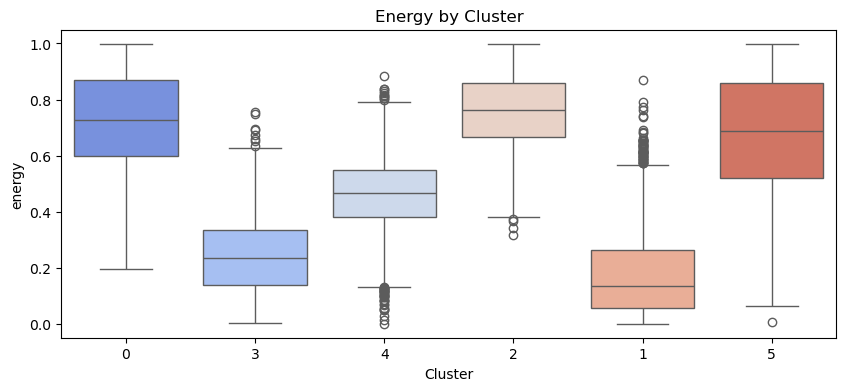

C:\Users\naman\AppData\Local\Temp\ipykernel_12580\553004632.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clustered_df, x='Cluster', y=feature, palette='coolwarm')


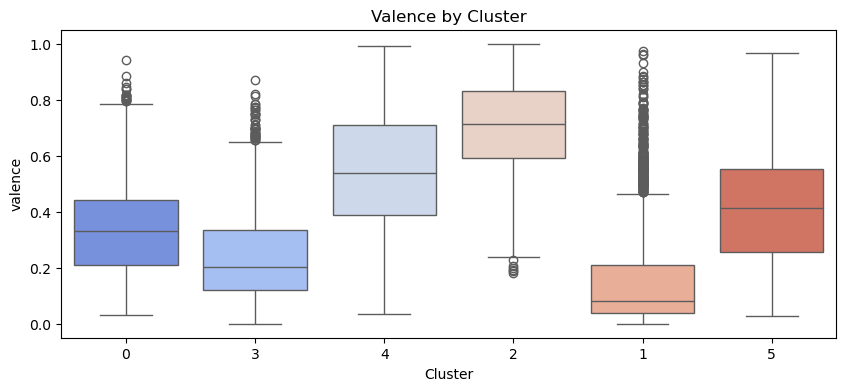

C:\Users\naman\AppData\Local\Temp\ipykernel_12580\553004632.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clustered_df, x='Cluster', y=feature, palette='coolwarm')


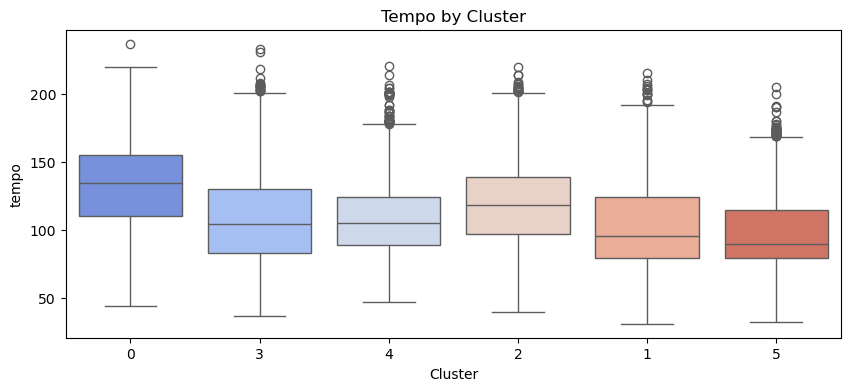

C:\Users\naman\AppData\Local\Temp\ipykernel_12580\553004632.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clustered_df, x='Cluster', y=feature, palette='coolwarm')


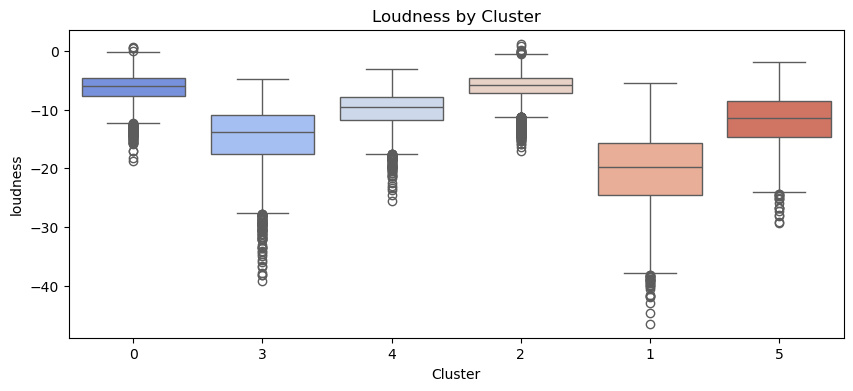

C:\Users\naman\AppData\Local\Temp\ipykernel_12580\553004632.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clustered_df, x='Cluster', y=feature, palette='coolwarm')


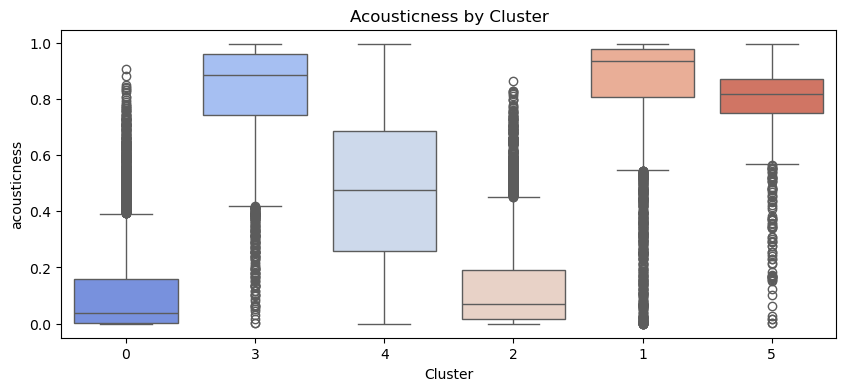

C:\Users\naman\AppData\Local\Temp\ipykernel_12580\553004632.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clustered_df, x='Cluster', y=feature, palette='coolwarm')


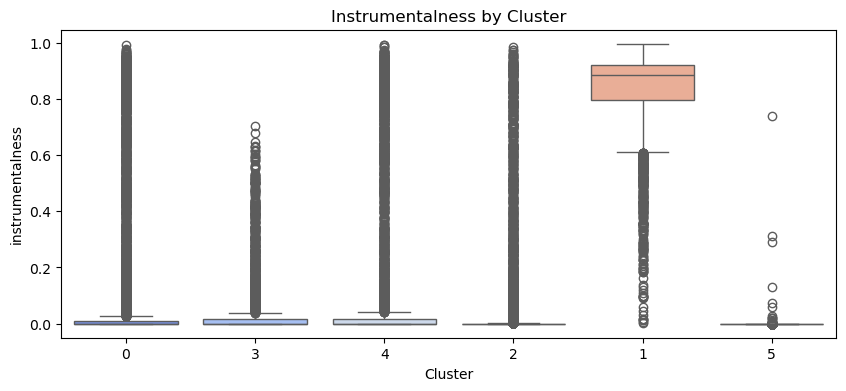

C:\Users\naman\AppData\Local\Temp\ipykernel_12580\553004632.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clustered_df, x='Cluster', y=feature, palette='coolwarm')


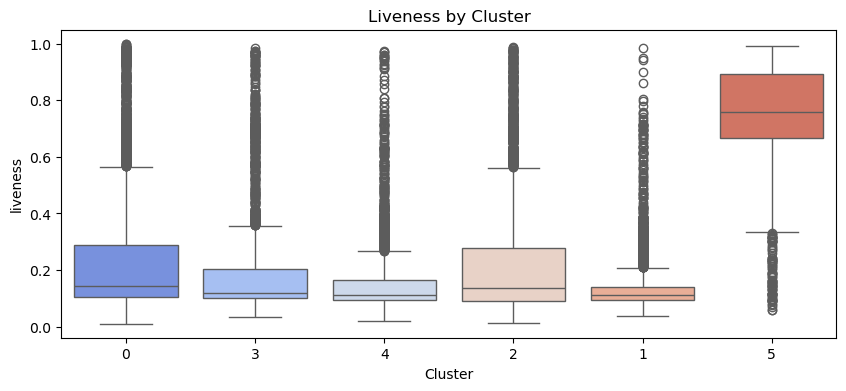

C:\Users\naman\AppData\Local\Temp\ipykernel_12580\553004632.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clustered_df, x='Cluster', y=feature, palette='coolwarm')


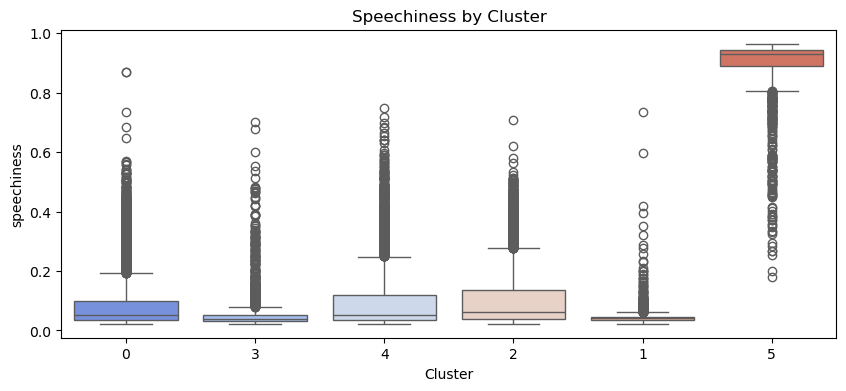

In [16]:
for feature in features: 
    plt.figure(figsize=(10, 4)) 
    sns.boxplot(data=clustered_df, x='Cluster', y=feature, palette='coolwarm') 
    plt.title(f"{feature.capitalize()} by Cluster")
    plt.show()



## Step 16: Heatmap of Cluster Averages


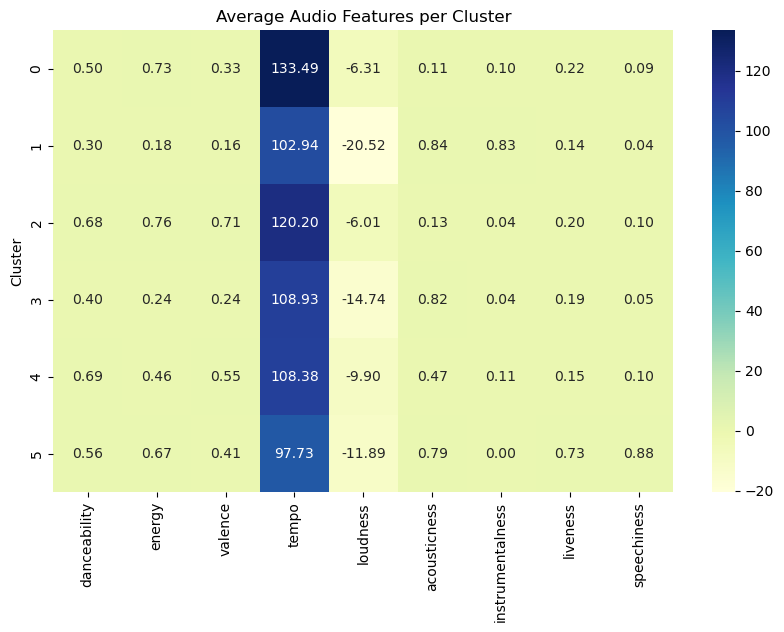

In [17]:
cluster_summary = clustered_df.groupby('Cluster')[features].mean()
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_summary, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Average Audio Features per Cluster")
plt.show()


## Step 17: Distribution Plot of Danceability

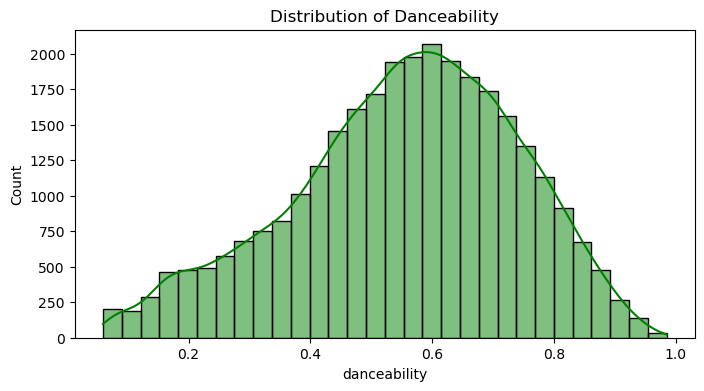

In [18]:
plt.figure(figsize=(8, 4)) 
sns.histplot(data=clustered_df, x='danceability', kde=True, bins=30, color='green') 
plt.title("Distribution of Danceability") 
plt.show()


## Step 18: Count of Songs per Cluster


C:\Users\naman\AppData\Local\Temp\ipykernel_12580\3663293539.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=clustered_df, palette='tab10')


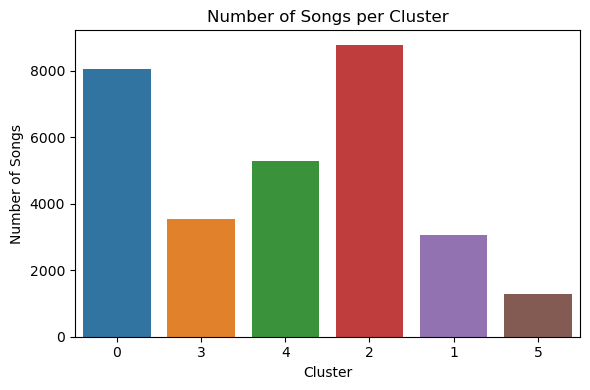

In [19]:
# Step 18: Count of Songs per Cluster
plt.figure(figsize=(6, 4))
sns.countplot(x='Cluster', data=clustered_df, palette='tab10')
plt.title("Number of Songs per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Songs")
plt.tight_layout()
plt.show()

# STEPS TAKEN ABOVE-:

📌 Step 1: Import Libraries

Import all essential libraries for data preprocessing, clustering, evaluation, and visualization.


---

📌 Step 2: Load Dataset

Read the SpotifyFeatures.csv file containing songs and their audio features.


---

📌 Step 3: Select Important Features

From the dataset, choose 9 relevant audio-based features such as:

Danceability

Energy

Valence

Tempo

Loudness

Acousticness

Instrumentalness

Liveness

Speechiness


These are numerical values used to describe the mood, rhythm, and structure of each song.


---

📌 Step 4: Downsample Dataset (Optional)

To improve speed, randomly sample 30,000 songs from the dataset.


---

📌 Step 5: Standardize Features

Use StandardScaler to scale all features. This ensures that all features contribute equally to the clustering algorithm.


---

📌 Step 6: Apply MiniBatch K-Means Clustering

Cluster the songs into 6 groups using the MiniBatchKMeans algorithm, which is efficient for large datasets.


---

📌 Step 7: Evaluate K-Means Clustering

Use the following metrics to assess the clustering quality:

Silhouette Score: Measures how well a song fits into its assigned cluster.

Davies–Bouldin Index: Compares the distance between clusters.



---

📌 Step 8: Apply DBSCAN Clustering (Optional)

Use DBSCAN, a density-based clustering method that can detect noise and clusters of varying shapes. It's slower and more sensitive to parameters.


---

📌 Step 9: Visualize Clusters

Create a 2D scatter plot of the first two scaled features to see how songs are grouped by K-Means.


---

📌 Step 10: Add Cluster Labels to Dataset

Assign the predicted cluster label to each song so it can be used for analysis or recommendation.


---

📌 Step 11: Recommend Similar Songs

Create a function that recommends n random songs from the same cluster as a given song index. This forms the core of the recommendation engine.


---

📌 Step 12: Predict Cluster for a Specific Song

Create a function to return the cluster of a song by its name, so users can explore songs by mood or style.


---

📌 Step 13: Show Average Features per Cluster

Summarize each cluster by calculating the average value of each audio feature per group. This helps interpret the type of songs in each cluster.


---

📌 Step 14: Save the Model

Use joblib to save both the trained K-Means model and the StandardScaler for future use without retraining.


---

📊 Seaborn Visualizations Used

📈 Plot Type	Purpose

Scatterplot	Show clusters in 2D (e.g., Danceability vs Energy)
Pairplot	Visualize pairwise feature distributions per cluster
Boxplot	Compare each feature across clusters
Heatmap	Show average audio features per cluster
Histogram	Explore the distribution of individual features
Countplot	Display how many songs belong to each cluster



---

🧠 Insights Gained

Songs with similar musical characteristics cluster together.

We can recommend similar songs without any labeled data.

Clustering is a great unsupervised approach for music recommendation systems.



---